**PROJECT 4** (due 20 April)

(i) Develop a Colab tutorial to illustrate the concept of probability distributions of following types with examples – normal/Gaussian, exponential, Poisson.

(ii) Spikes arriving at a neuron typically is a Poisson process. The firing of a neuron is often modeled also as a Poisson process. Download this in vivo spike data, show that the spikes of a neuron is a Poisson process (OR NOT) by fitting a Poisson distribution. Also show that the inter-spike intervals follow an exponential distribution (OR NOT). Plot both the histogram of data samples and the fit distribution curve in the same figure. Include all codes you use to process the data in a notebook, keeping all results, and explain your findings in markdowns. Note the followings:

1. Data description: The data is downloaded from a public dataset hc-3 which contains LFP recordings from hippocampal areas of rats. This (http://crcns.org/data-sets/hc/hc-3/about-hc-3) website provides an overview of the dataset. The spike data you need is in the two folders "ec012" and "ec016" in the zip folder you downloaded, each recorded from a rat. In each folder, there are several data files with name format "xxxxx.yyy.res.zz", where xxxxx is the id of a rat, yyy is the session id and zz is a neuron id. There are two neurons for each session. The files can be opened or read in programs as text files. There is one single column in each file recording the spike times. Each value in the column is an integer of the time index in the recording of a session. The sampling rate is 20kHz, so each time step is 0.05 ms. You are required to check all the 14 files provided. You don't need to show results for all but choose at least THREE, which you think can represent a variety of cases among them.

2. You need to use maximum likelihood estimation (MLE) to fit the distributions to your data samples. Then calculate the mean of the data samples and compare it with the resulting distribution parameter and check whether they agree, i.e. to show that the MLE for fitting Poisson distribution and exponential distribution is equivalent to simply calculating the sample mean.

3. When you fit Poisson distribution to the number of spikes, different selection of time interval length may result in different distribution. Some cases may fit well to Poisson, some may not. You can use Fano factor (variance/mean) to evaluate whether its close to Poisson distribution. Poisson distribution has a Fano factor that equals 1. Do summarize what you found when you try different time intervals. Also, when you fit exponential distribution to inter-spike intervals and find it does not fit well, try to explain why.

4. (Optional) Explore more data from on this public dataset (Links to an external site.). You can find two pdf documents with detailed explanation of the dataset in the zip folder you downloaded. The rats were performing different behavioral tasks in different sessions. You can find a list of info for each session in the file hc3-session.csv. The spike time data is in the files with "res" in their name. You can explore with more data how the spike statistics differ in different neurons, under different behavioral tasks.

# (i) Probability Distributions

A probability distribution is the mathematical function that gives the probabilities of occurrence of different possible outcomes for an experiment. This distribution describes a random variable by associating a probaility with every possible outcome across the entire sample space. This distribution can either be discrete (probability mass function, PMF) or continuous (probability density function, PDF), depending on whether the variable it describes takes on discrete or continuous values. Random variables can be described by a probability distribution of any shape, but a large majority of variables have probability distributions belonging to one of several common stereotyped classes which we shall explore here.

Adapted from: https://en.wikipedia.org/wiki/Probability_distribution

The most common probability distribution is the normal or gaussian pdf. This distribution is symmetric across its average/mean value. The width or spread of the distribution is described by its standard deviation. Mean and std are represented by the greek letters μ and σ. A gaussian distribution is described by the equation:

\begin{align}
f(x)= {\frac{1}{\sigma\sqrt{2\pi}}}e^{- {\frac {1}{2}} (\frac {x-\mu}{\sigma})^2}
\end{align}

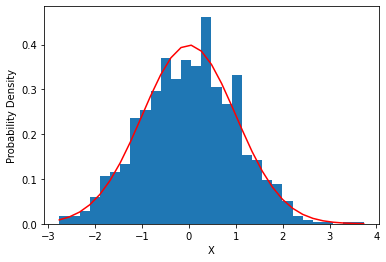

In [ ]:
# Generate random samples from a gaussian distribution 
from scipy.stats import norm
size = 1000 # num of points
n = norm.rvs(loc=0, scale=1, size=size) # mean = 0, std = 1

# Plot histogram and probability density function (pdf)
import matplotlib.pyplot as plt
_, bins, _ = plt.hist(n, bins=30, density=True)
plt.plot(bins, norm.pdf(bins), 'r')
plt.ylabel('Probability Density')
plt.xlabel('X')
plt.show()

Another common distribution is the exponential distribution. This distribution is defined by a single rate parameter lambda (λ). This distribution also represents the time between events occuring in a poisson process, the next distribution we shall discuss. The distribution is described by the equation:

\begin{align}
f(x) = \begin{cases} \lambda e^{-\lambda x} & x\geq 0 \\ 0 & x<0 \end{cases}
\end{align}

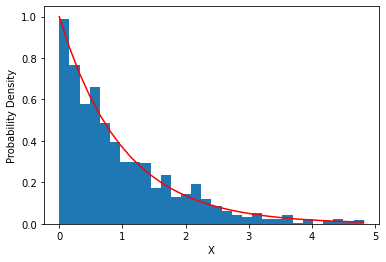

In [ ]:
# Generate random samples from an exponential distribution 
from scipy.stats import expon
e = expon.rvs(scale=1, size=size) # lambda = 1

# Plot histogram and pdf
_ , bins, _ = plt.hist(e, bins=30, density=True)
plt.plot(bins, expon.pdf(bins), 'r')
plt.ylabel('Probability Density')
plt.xlabel('X')
plt.show()

Finally, the poisson distribution is a means of describing the probability of a given number of events occurring in a fixed interval of time or space, assuming these events occur with a known constant mean rate (λ). Since events either occur or do not occur, the poisson distribution describes a discrete random variable and is therefore a probability mass function. A poisson distribution is described by the following equation:

\begin{align}
\!f(k)=\frac{\lambda^k e^{-\lambda}}{k!}
\end{align}

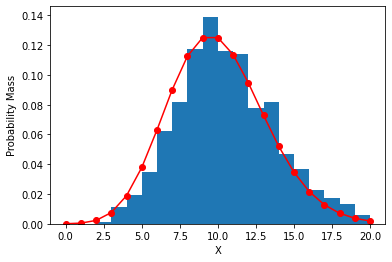

In [ ]:
# Generate random samples from a poisson distribution 
from scipy.stats import poisson
lam = 10
p = poisson.rvs(mu=lam, size=size) # lambda = 5, note: lambda = mu in a poisson distribution

# Plot histogram and pmf
bins = range(max(p))
plt.hist(p, bins=bins, density=True)
plt.plot(bins, poisson.pmf(bins,lam), marker='o', color='r')
plt.ylabel('Probability Mass')
plt.xlabel('X')
plt.show()

# (ii) Modeling the Firing of a Neuron as a Poisson Process

# Download Dataset

In [ ]:
# Mount to Drive, Access Data Folder
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Neural Models and Machine Learning/Project 4'
%ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Neural Models and Machine Learning/Project 4
 crcns-hc3-data-description.pdf      'data source.txt'   ec016/
 crcns-hc3-processing-flowchart.pdf   ec012/             hc3-session.csv


In [ ]:
"""
Here we will read all of the provided spike data into two arrays, one for each folder
Dictionaries can be indexed by filename to access spike data
Note: For a given file "xxxxx.yyy.res.zz", xxxxx = ratID, yyy = sessionID, and zz = neuronID
"""

import numpy as np

fs = 1 / 20000 # 20kHz

def get_spikes(filename, fs):
  with open(filename) as f:
      data = f.read()
      data = data.split()
      return np.array(data).astype(float) * fs # scale spike times by sampling frequency

%cd '/content/drive/MyDrive/Colab Notebooks/Neural Models and Machine Learning/Project 4/ec012'
filenames = ['ec012ec.187.res.1','ec012ec.228.res.1','ec012ec.375.res.1',
             'ec012ec.187.res.2','ec012ec.228.res.2','ec012ec.375.res.2']

spikes_ec012 = {filename: get_spikes(filename, fs) for filename in filenames}

%cd '/content/drive/MyDrive/Colab Notebooks/Neural Models and Machine Learning/Project 4/ec016'
filenames = ['ec016.272.res.1','ec016.457.res.1','ec016.674.res.1','ec016.682.res.1',
             'ec016.272.res.2','ec016.457.res.2','ec016.674.res.2','ec016.682.res.2']

spikes_ec016 = {filename: get_spikes(filename, fs) for filename in filenames}

print('Complete')

/content/drive/MyDrive/Colab Notebooks/Neural Models and Machine Learning/Project 4/ec012
/content/drive/MyDrive/Colab Notebooks/Neural Models and Machine Learning/Project 4/ec016
Complete


# Fit Distributions to Experimental Data

In [ ]:
"""
In this block I create some functions which we will use to fit poisson distributions
to our data. More specifically, we will examine the distribution of spikes per unit time
(a variable dt of our choosing). We will use Maximum Likelihood Estimation to calculate our parameter lambda.
"""

from math import ceil
from scipy.optimize import minimize

# Use np.histogram to find the number of spikes within each time segment of length dt
def spike_per_time(spikes,dt):
    t_segs = np.arange(0, ceil(spikes[-1]), dt)
    spt, _ = np.histogram(spikes, bins=t_segs)
    return spt, dt

# Calculate negative log likelihood based on a poisson distribution
def poissonNLL(lam):
    return -np.sum(poisson.logpmf(spt, mu=lam))

def get_poisson_param(spt):

    # Find value of lambda that minimizes the log likelihood
    lam_MLE = minimize(poissonNLL, 1, method='Nelder-Mead').x[0] # lam_init = 1

    # Estimate lambda with a simple average
    lam_AVG = sum(spt) / spt.size

    return lam_MLE, lam_AVG

filename = 'ec012ec.228.res.1'
spikes = spikes_ec012[filename]
spt, dt = spike_per_time(spikes,0.1)
lam_MLE, lam_AVG = get_poisson_param(spt)

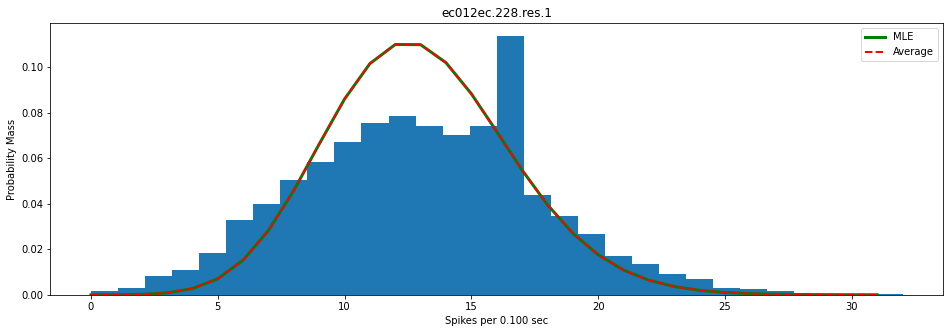

In [ ]:
# Plot Results

def plot_poisson_dist(spt,lam_MLE,lam_AVG,title,dt,fsize):
    plt.figure(figsize=fsize)
    _, bins, _ = plt.hist(spt, bins=30, density=True)

    x = range(round(max(bins)))

    p_MLE = poisson.pmf(x, lam_MLE)
    plt.plot(x, p_MLE, linewidth=3, color='g', label='MLE')

    p_AVG = poisson.pmf(x, lam_AVG)
    plt.plot(x, p_AVG, linewidth=2, linestyle='--', color='r', label='Average')

    plt.title(title)
    plt.ylabel('Probability Mass')
    plt.xlabel('Spikes per %.3f sec' % dt)
    plt.legend()
    plt.show()

plot_poisson_dist(spt,lam_MLE,lam_AVG,filename,dt,(16,5))

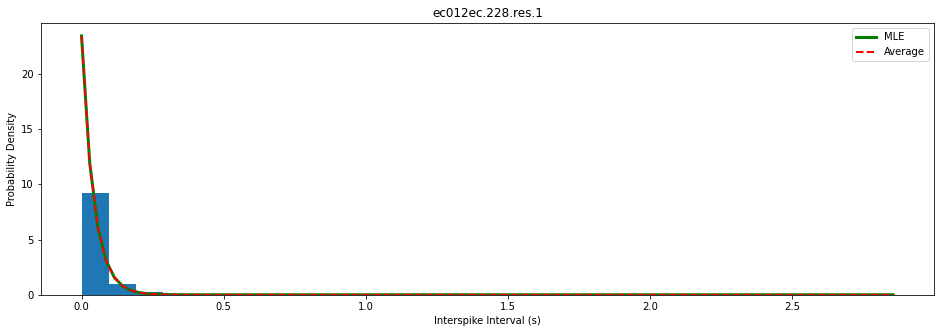

In [ ]:
"""
Here we will write similar functions to fit an exponential function to a new subset of our data,
the interspike time interval. Once again, the parameter lambda which determines the shape of this function is
calculated with MLE and then compared to another value of lambda calculated as a simple average.
"""

def get_spike_intervals(spikes):
    return np.array([spikes[i+1] - spikes[i] for i in range(spikes.size-1)])

# Calculate negative log likelihood based on an exponential distribution
def exponNLL(lam):
    return -np.sum(expon.logpdf(spaces, scale=1/lam)) # scale = mu = 1 / lam

def get_expon_param(spaces):
    # Find value of lambda that minimizes the log likelihood
    lam_MLE = minimize(exponNLL, 1, method='Nelder-Mead').x[0] # lam_init = 1

    # Estimate lambda with a simple average (inverse)
    lam_AVG = spaces.size / sum(spaces) 

    return lam_MLE, lam_AVG

def plot_expon_dist(spaces,lam_MLE,lam_AVG,title,fsize):
    plt.figure(figsize=fsize)

    _, bins, _ = plt.hist(spaces, bins=30, density=True)

    x = np.linspace(0,max(bins),100)

    e_MLE = expon.pdf(x, scale=1/lam_AVG)
    plt.plot(x, e_MLE, linewidth=3, color='g', label='MLE')

    e_AVG = expon.pdf(x, scale=1/lam_AVG)
    plt.plot(x, e_AVG, linewidth=2, linestyle='--', color='r', label='Average')
    
    plt.legend()
    plt.title(title)
    plt.ylabel('Probability Density')
    plt.xlabel('Interspike Interval (s)')
    plt.show()

spaces = get_spike_intervals(spikes)
lam_MLE, lam_AVG = get_expon_param(spaces)
plot_expon_dist(spaces,lam_MLE,lam_AVG,filename,(16,5))

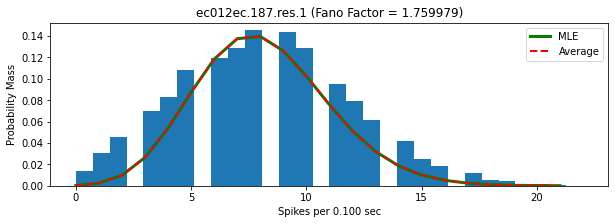

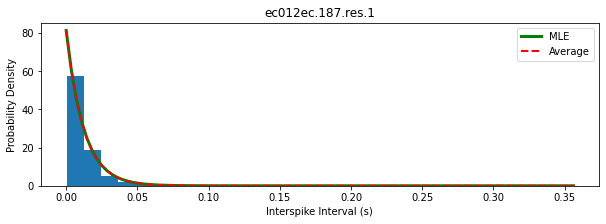

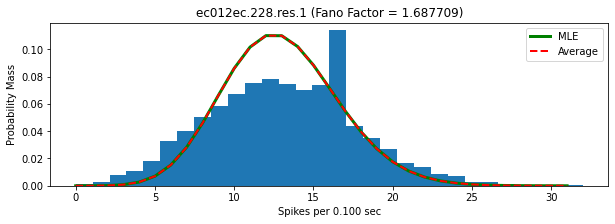

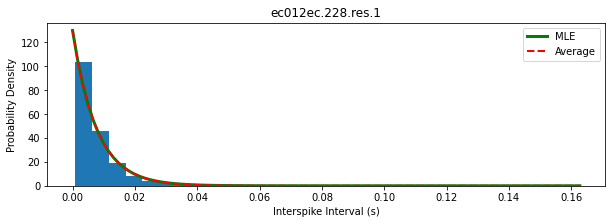

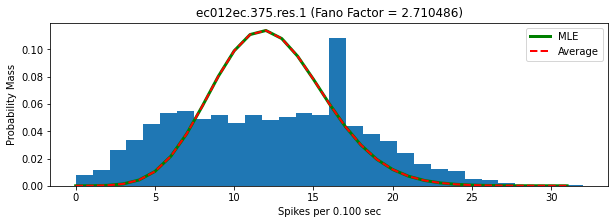

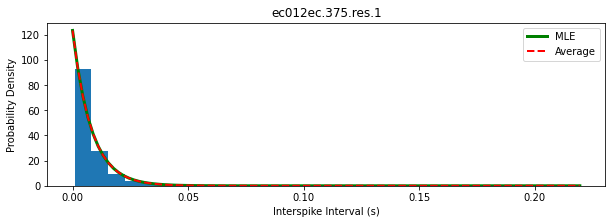

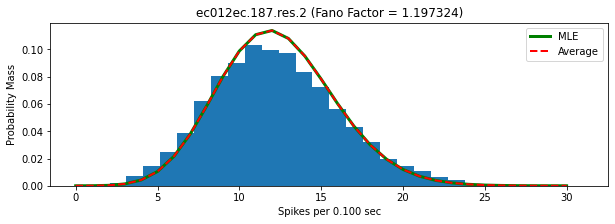

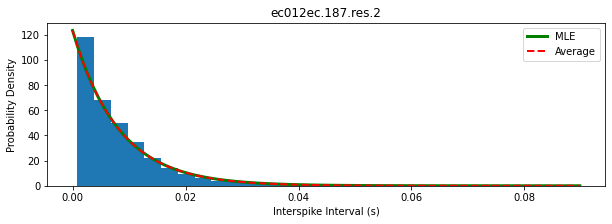

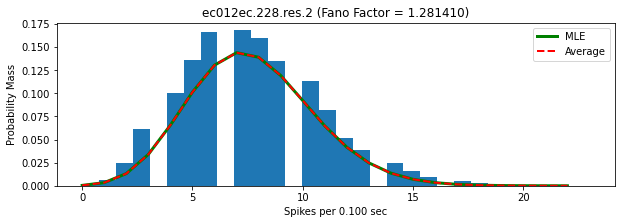

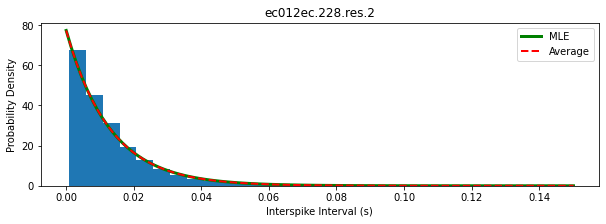

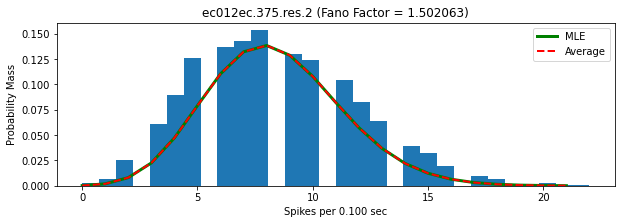

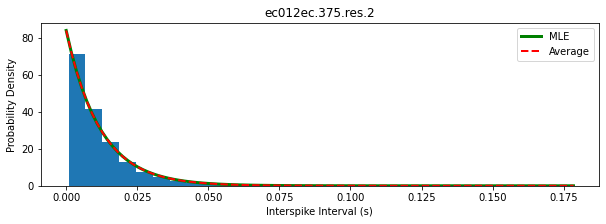

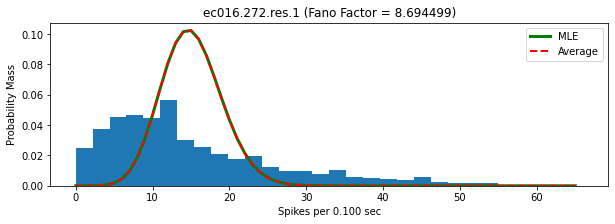

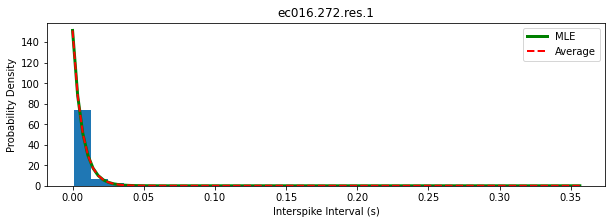

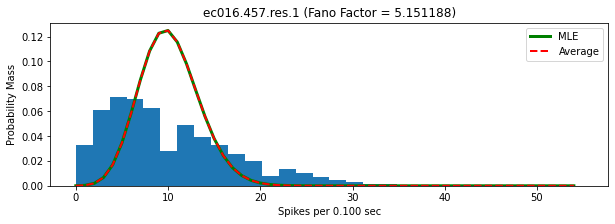

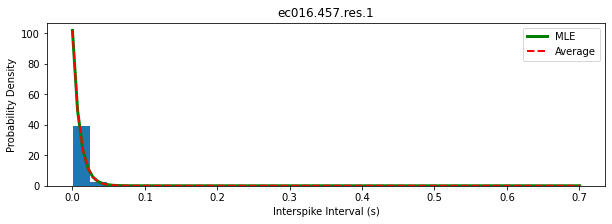

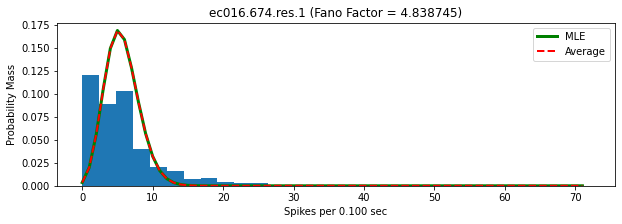

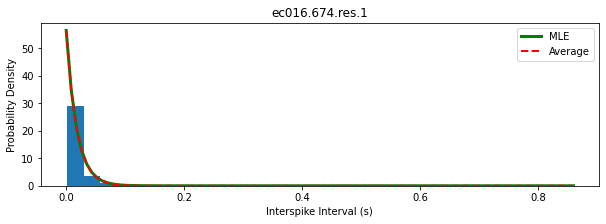

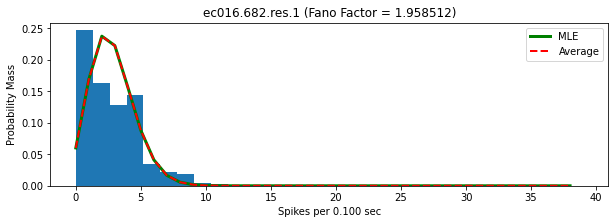

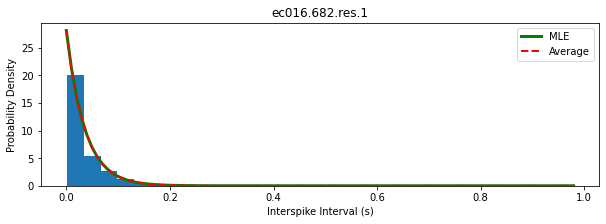

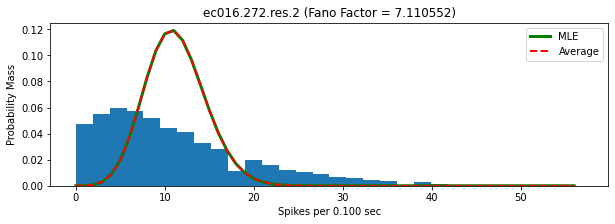

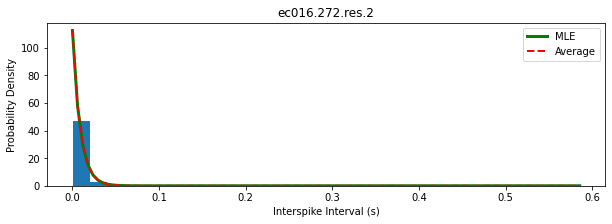

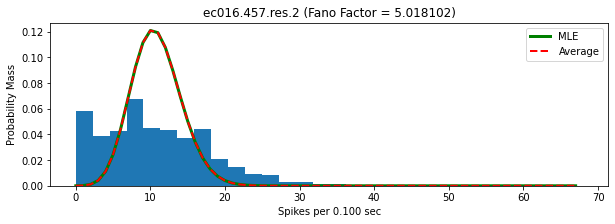

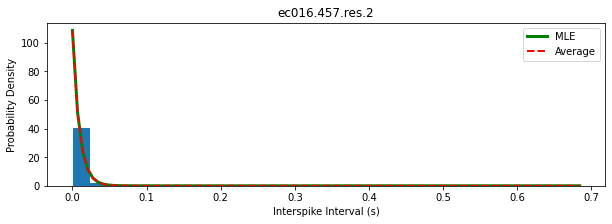

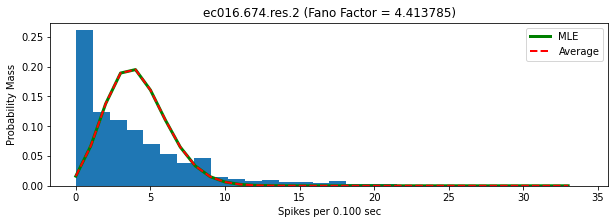

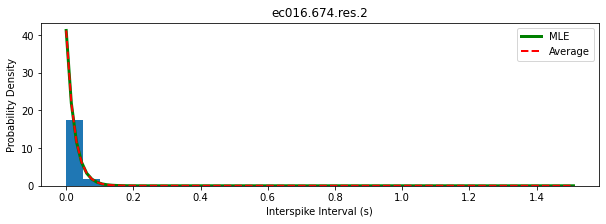

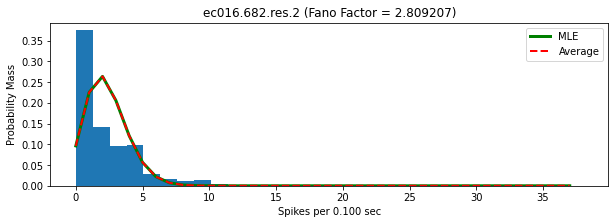

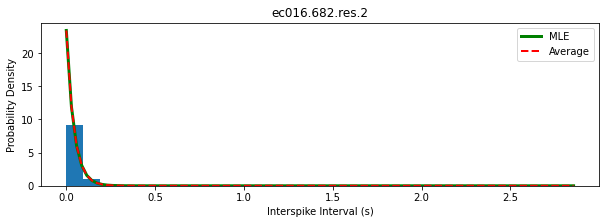

In [ ]:
from scipy import stats
"""
# The Fano Factor (FF) is a simple metric used to measure the dispersion of a distribution
# A poisson process will have FF = 1, thus each distribution's FF will represent a measure of
# how closely it fits to a poisson process. The closer to 1, the better the fit.
"""
def get_fano_factor(data):
    _, _, mean, variance, _, _ = stats.describe(data)
    return variance / mean

def fit_poisson_dist(spikes, dt, filename):
    global spt # quick fix to ensure get_poisson_param has access to latest spt
    spt, dt = spike_per_time(spikes, dt)
    lam_MLE, lam_AVG = get_poisson_param(spt)
    title = filename + (' (Fano Factor = %f)' % get_fano_factor(spt))
    plot_poisson_dist(spt, lam_MLE, lam_AVG, title, dt, (10,3))

def fit_expon_dist(spikes, filename):
    spaces = get_spike_intervals(spikes)
    lam_MLE, lam_AVG = get_expon_param(spaces)
    plot_expon_dist(spaces, lam_MLE, lam_AVG, filename, (10,3))

# Quick Examination of Procedure applied to all samples
for fname in spikes_ec012.keys():
    spikes = spikes_ec012[fname]
    fit_poisson_dist(spikes, 0.1, fname)
    fit_expon_dist(spikes, fname)

for fname in spikes_ec016.keys():
    spikes = spikes_ec016[fname]
    fit_poisson_dist(spikes, 0.1, fname)
    fit_expon_dist(spikes, fname)

The following block of code examines 3 different samples and how well they can be estimated as poisson processes.
* The first sample matches our intuitions quite well. When plotting the distribution of spikes in our selected time window (0.1 sec), we measure a Fano Factor of ~1.20. This is one of the best fits we see across all of our data. We can safely assume that it can be modeled as a poisson process. The plot of the distribution of interspike intervals also fits quite well with the exponential function we calculated with MLE.
* This sample does not offer quite the same caliber of results. Here we can see that the same window size of 0.1 sec does not produce results that match a poisson process. However, we can improve our approximation by choosing a smaller window. A window of 25 msec produces a distribution which begins to look more like a poisson process, but with a FF ~= 4.06, this approximation is a bit of a stretch.
* The final sample demonstrates a case in which our distribution is heavily concentrated near zero. By altering our window size, we can once again acheive a very loose approximation with a FF ~= 4.28, but this is certainly not as accurate of an approximation as we achieved with the first example.

While some data sets don't perfectly match a poisson process, I think that if we take into consideration a large number of samples over a long enough period of time, it is a reasonable assumption to consider the firing of a neuron to be a poisson process. Thus we also must consider the interval of time taking place between spikes to follow an exponential distribution.

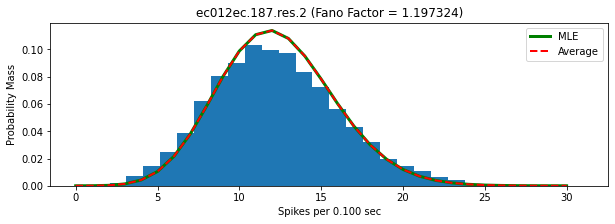

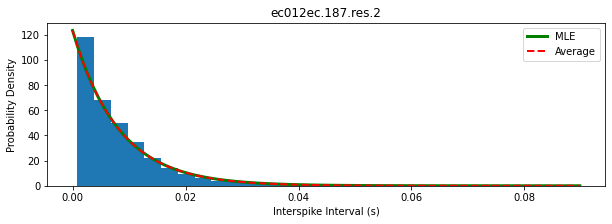

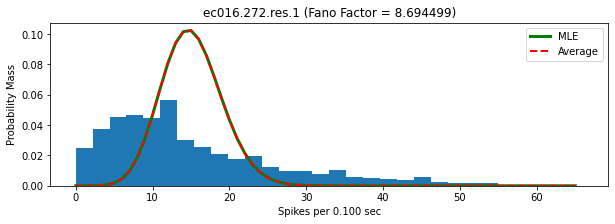

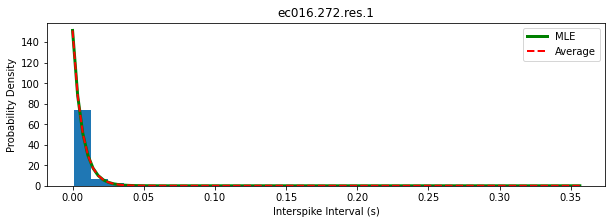

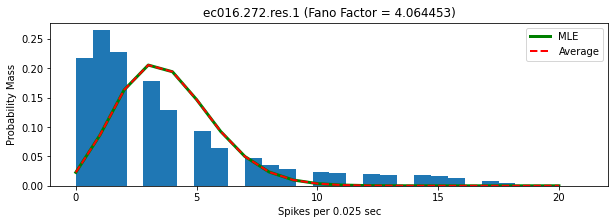

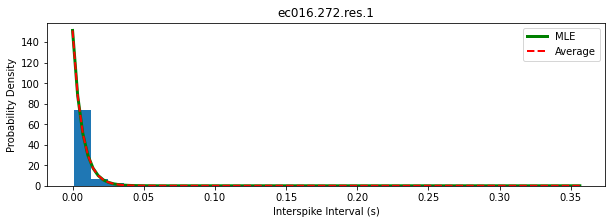

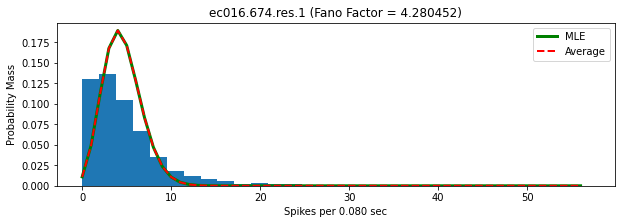

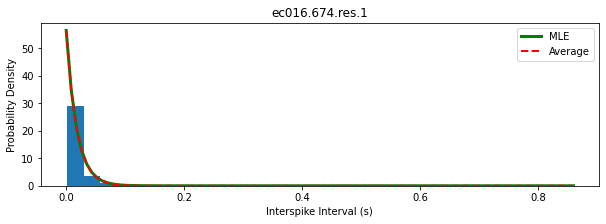

In [ ]:
# Cases of Particular Interest

fname = 'ec012ec.187.res.2'
spikes = spikes_ec012[fname]
fit_poisson_dist(spikes, 0.1, fname)
fit_expon_dist(spikes, fname)

fname = 'ec016.272.res.1'
spikes = spikes_ec016[fname]
fit_poisson_dist(spikes, 0.1, fname)
fit_expon_dist(spikes, fname)
fit_poisson_dist(spikes, 0.025, fname)
fit_expon_dist(spikes, fname)

fname = 'ec016.674.res.1'
spikes = spikes_ec016[fname]
fit_poisson_dist(spikes, 0.08, fname)
fit_expon_dist(spikes, fname)